## **5. Tecnicas de Optimizacion para Clasificador Bayesiano**

Se selccionan las variables explicativas y la respuesta.

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_curve, roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
import time

In [20]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [21]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

Se separan el conjunto de entrenamiento y test.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creamos vectores con cada tipo de variable para hacer el correcto manejo de las variables antes de modelar.

In [23]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

A continuación, se crean los pipelines de preprocesamiento, modelo logístico con gridsearch y validación ccruzada estratificada, y modelo de knn con gridsearch y vlaidación cruzada estratificada.

In [24]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [ ]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    print(f"\n{nombre_modelo}")
    print(f"Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")
    if auc:
        print(f"AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred))

    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.legend()
        plt.show()

    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }


## **5.1.1 Clasificador Bayesiano estandar**

In [26]:
t0 = time.time()
bayes_normal = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", GaussianNB())
])

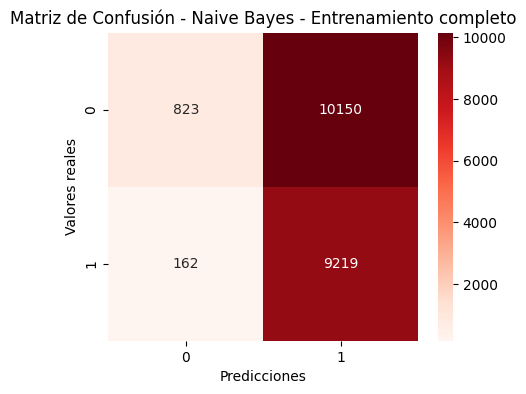


📊 Naive Bayes - Entrenamiento completo
Accuracy: 0.493 | Precision: 0.476 | Recall: 0.983 | F1: 0.641
AUC: 0.642
              precision    recall  f1-score   support

           0       0.84      0.08      0.14     10973
           1       0.48      0.98      0.64      9381

    accuracy                           0.49     20354
   macro avg       0.66      0.53      0.39     20354
weighted avg       0.67      0.49      0.37     20354



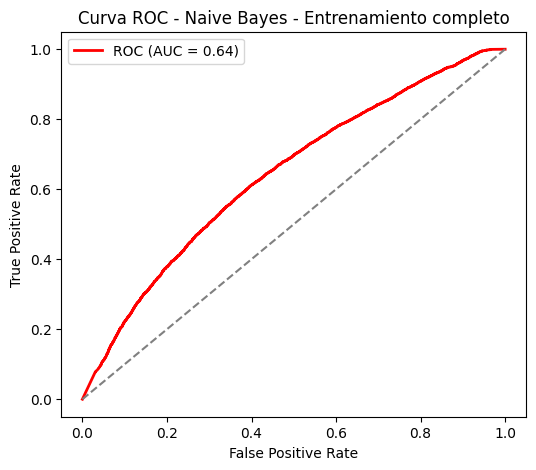

In [27]:
bayes_normal.fit(X_train, y_train)
t1 = time.time()

result_bayes_normal = evaluar_modelo(bayes_normal, X_test, y_test, "Naive Bayes - Entrenamiento completo")
result_bayes_normal["Tiempo (s)"] = round(t1 - t0, 3)

## **5.1 Clasificador Bayesiano usando tecnicas de optimizacion**

In [28]:
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

nb_incremental = GaussianNB()
clases = np.unique(y_train)
batch_size = 2000
t0 = time.time()

for i in range(0, len(X_train_proc), batch_size):
    X_batch = X_train_proc[i:i + batch_size]
    y_batch = y_train.iloc[i:i + batch_size]
    nb_incremental.partial_fit(X_batch, y_batch, classes=clases)

t1 = time.time()

In [29]:
y_pred = nb_incremental.predict(X_test_proc)
y_pred_proba = nb_incremental.predict_proba(X_test_proc)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

In [30]:
print("\n Naive Bayes Incremental (Partial Fit)")
print(f"Accuracy: {accuracy:.3f} | Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f} | AUC: {auc:.3f}")


 Naive Bayes Incremental (Partial Fit)
Accuracy: 0.494 | Precision: 0.476 | Recall: 0.983 | F1: 0.641 | AUC: 0.642


In [31]:
result_bayes_incremental = {
    "Modelo": "Naive Bayes Incremental",
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1": f1,
    "AUC": auc,
    "Tiempo (s)": round(t1 - t0, 3)
}

## 5. Resultados para Clasificador Bayesiano

In [32]:
tabla_resultados = pd.DataFrame([
    result_bayes_normal,
    result_bayes_incremental
])
print("\n Comparación de modelos:")
print(tabla_resultados)


 Comparación de modelos:
                                 Modelo  Accuracy  Precision    Recall  \
0  Naive Bayes - Entrenamiento completo  0.493367   0.475967  0.982731   
1               Naive Bayes Incremental  0.493515   0.476040  0.982731   

         F1       AUC  Tiempo (s)  
0  0.641322  0.642233       0.795  
1  0.641389  0.642218       0.216  


                                 Modelo  Accuracy  Precision    Recall  \
0  Naive Bayes - Entrenamiento completo  0.493367   0.475967  0.982731   
1               Naive Bayes Incremental  0.493515   0.476040  0.982731   

         F1       AUC  Tiempo (s)  
0  0.641322  0.642233       0.795  
1  0.641389  0.642218       0.216  


C:\Users\taran\AppData\Local\Temp\ipykernel_15104\2608458362.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modelo", y="F1", data=tabla_resultados, palette="Reds")


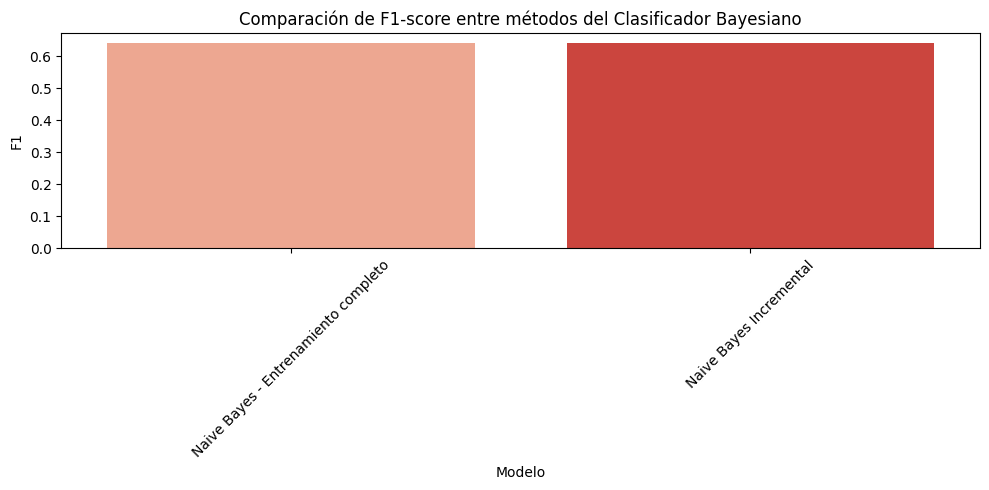

C:\Users\taran\AppData\Local\Temp\ipykernel_15104\2608458362.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modelo", y="Tiempo (s)", data=tabla_resultados, palette="Reds")


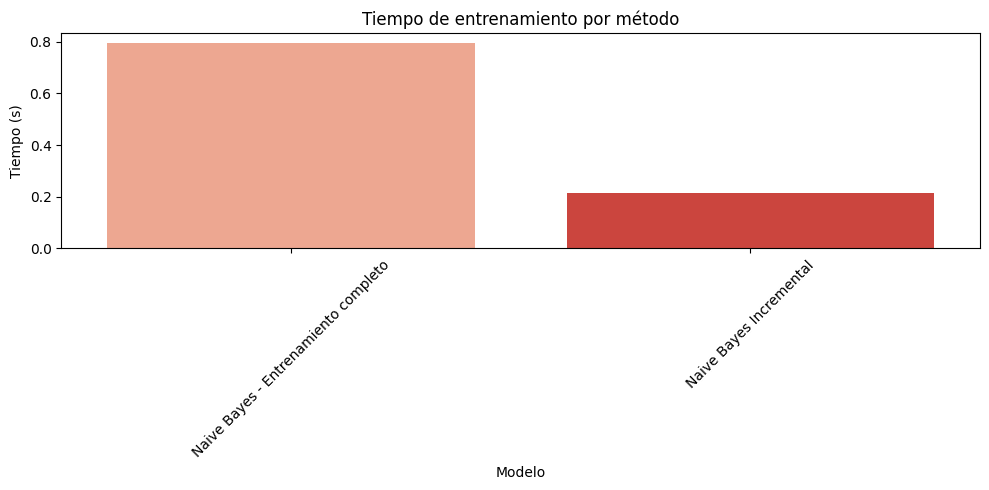

In [35]:
print(tabla_resultados)

#  Visualización comparativa
plt.figure(figsize=(10, 5))
sns.barplot(x="Modelo", y="F1", data=tabla_resultados, palette="Reds")
plt.title("Comparación de F1-score entre métodos del Clasificador Bayesiano")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x="Modelo", y="Tiempo (s)", data=tabla_resultados, palette="Reds")
plt.title("Tiempo de entrenamiento por método")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()